In [10]:
import os
import io
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Historical data

In [11]:
file_path = "../Data_Modelling/Visitors/entrance_data_cleaned.csv"

combined_entance_table = pd.read_csv(file_path)

In [12]:
def fetch_knmi_data(start_date, end_date, station=240):
    """
    Fetch weather data from KNMI API.

    Parameters:
        start_date (str): Start date in 'YYYYMMDD' format.
        end_date (str): End date in 'YYYYMMDD' format.
        station (int): Weather station number (default 240 = Amsterdam Schiphol).

    Returns:
        pd.DataFrame: Weather data with readable columns.
    """
    url = 'https://www.daggegevens.knmi.nl/klimatologie/daggegevens'
    params = {
        'stns': station,
        'vars': 'TG:RH:SQ',
        'start': start_date,
        'end': end_date
    }

    print(f"Fetching KNMI data from {start_date} to {end_date}...")
    response = requests.post(url, data=params)
    if response.status_code != 200:
        print(f"Error fetching data: {response.status_code}")
        print(response.text)
        return None

    lines = response.text.strip().split('\n')
    header, data_lines = None, []
    for line in lines:
        if line.startswith('# STN,'):
            header = line[2:].strip()
        elif not line.startswith('#'):
            data_lines.append(line)
    if not header or not data_lines:
        print("Failed to parse KNMI data")
        return None

    column_names = [col.strip() for col in header.split(',')]
    df = pd.read_csv(
        io.StringIO('\n'.join(data_lines)),
        sep=',',
        names=column_names,
        skipinitialspace=True
    )

    df['YYYYMMDD'] = pd.to_datetime(df['YYYYMMDD'], format='%Y%m%d')
    df.rename(columns={'YYYYMMDD': 'Date'}, inplace=True)
    if 'TG' in df.columns:
        df['TG'] = df['TG'] / 10.0
    if 'TX' in df.columns:
        df['TX'] = df['TX'] / 10.0
    if 'TN' in df.columns:
        df['TN'] = df['TN'] / 10.0
    if 'RH' in df.columns:
        df['RH'] = df['RH'] / 10.0

    column_mapping = {
        'TG': 'MeanTemp_C',
        'TX': 'MaxTemp_C',
        'TN': 'MinTemp_C',
        'RH': 'Precipitation_mm',
        'SQ': 'Sunshine_hours',
    }
    rename_cols = {k: v for k, v in column_mapping.items() if k in df.columns}
    df.rename(columns=rename_cols, inplace=True)
    return df

In [13]:
def get_weather_forecast(api_key, location, days=3):
    """
    Get weather forecast for a location using WeatherAPI.com.

    Parameters:
        api_key (str): Your WeatherAPI.com API key.
        location (str): Location name, zip code, or lat,lon coordinates.
        days (int): Number of days of forecast (1-14).

    Returns:
        dict: Weather forecast data.
    """
    url = "https://api.weatherapi.com/v1/forecast.json"
    params = {
        'key': api_key,
        'q': location,
        'days': days,
        'aqi': 'no',
        'alerts': 'no'
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as err:
        print(f"Request error occurred: {err}")
    except json.JSONDecodeError as json_err:
        print(f"JSON decode error: {json_err}")
    return None

In [14]:
def create_df_from_forecast(forecast):
    """
    Convert WeatherAPI forecast JSON to DataFrame.

    Parameters:
        forecast (dict): WeatherAPI forecast JSON.

    Returns:
        pd.DataFrame: DataFrame with date, avgtemp_c, totalprecip_mm.
    """
    forecastdays = forecast["forecast"]["forecastday"]
    result = {
        "date": [],
        "avgtemp_c": [],
        "totalprecip_mm": []
    }
    for day in forecastdays:
        result["date"].append(day["date"])
        result["avgtemp_c"].append(day["day"]["avgtemp_c"])
        result["totalprecip_mm"].append(day["day"]["totalprecip_mm"])
    return pd.DataFrame(result)

Fetching KNMI data from 20220126 to 20250619...


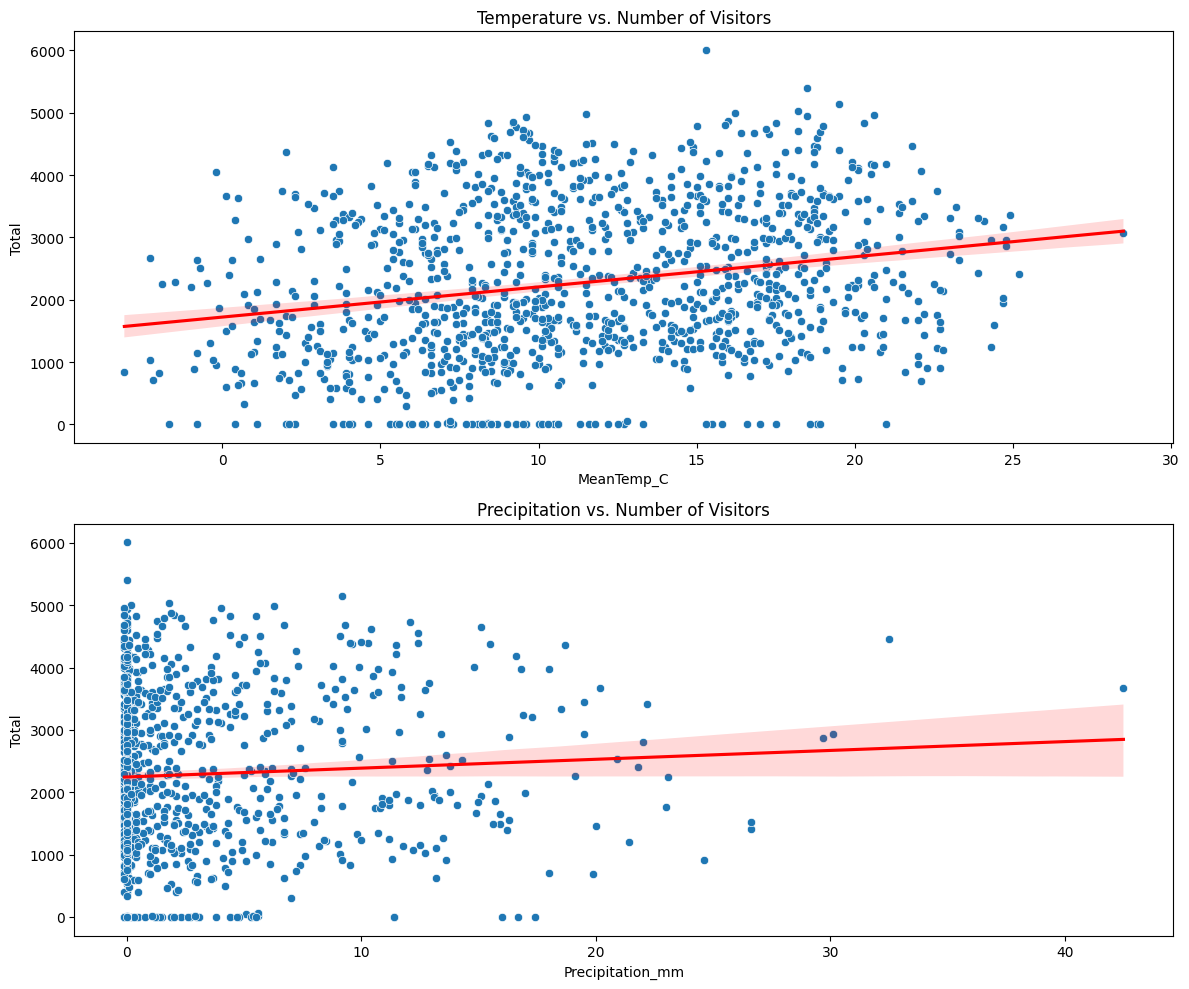


Correlation between weather factors and visitors:
                     Total  MeanTemp_C  Precipitation_mm
Total             1.000000    0.229409          0.055424
MeanTemp_C        0.229409    1.000000         -0.016763
Precipitation_mm  0.055424   -0.016763          1.000000


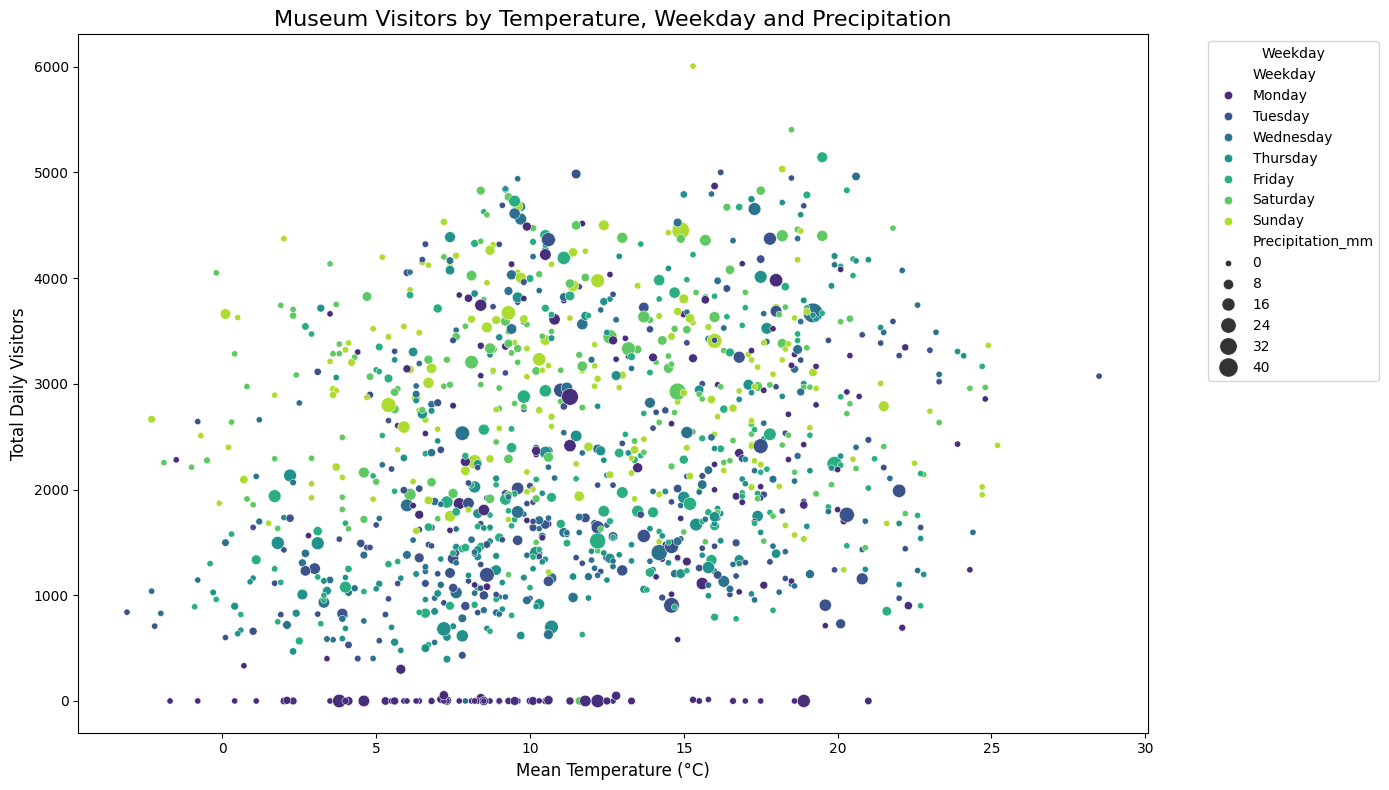

In [15]:

entrance_file = "../Data_Modelling/Visitors/entrance_data_cleaned.csv"
combined_entrance_table = pd.read_csv(entrance_file)
combined_entrance_table["Date"] = pd.to_datetime(combined_entrance_table['Date'])

start_date = combined_entrance_table['Date'].min().strftime('%Y%m%d')
end_date = datetime.now().strftime('%Y%m%d')

weather_data = fetch_knmi_data(start_date, end_date)

if weather_data is not None:
    if "STN" in weather_data.columns:
        weather_data = weather_data.drop(columns=["STN"])
    weather_data['Date'] = pd.to_datetime(weather_data['Date'])
    if "Sunshine_hours" in weather_data.columns:
        weather_data["Sunshine_hours"] = weather_data["Sunshine_hours"] * 0.1

    # Fill missing dates
    date_range = pd.date_range(start=weather_data['Date'].min(), end=weather_data['Date'].max())
    complete_df = pd.DataFrame({'Date': date_range})
    filled_df = pd.merge(complete_df, weather_data, on='Date', how='left')
    columns_to_fill = ["MeanTemp_C", "Precipitation_mm", "Sunshine_hours"]
    for col in columns_to_fill:
        if col in filled_df.columns:
            filled_df[col] = filled_df[col].fillna(0).astype(float)
    filled_df = filled_df.sort_values('Date')

    # Save cleaned data
    cleaned_data_path = "../../Data_Sources/Data_Modelling/Weather"
    os.makedirs(cleaned_data_path, exist_ok=True)
    output_file = os.path.join(cleaned_data_path, "weather_data.csv")
    filled_df.to_csv(output_file, index=False)

    # --- Visualization (optional) ---
    daily_visitors = combined_entrance_table.groupby('Date')['Total'].sum().reset_index()
    merged_data = pd.merge(daily_visitors, filled_df, on='Date', how='inner')

    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    sns.scatterplot(data=merged_data, x='MeanTemp_C', y='Total', ax=axes[0])
    axes[0].set_title('Temperature vs. Number of Visitors')
    axes[0].set_xlabel('Mean Temperature (°C)')
    axes[0].set_ylabel('Total Daily Visitors')
    sns.regplot(data=merged_data, x='MeanTemp_C', y='Total', scatter=False, ax=axes[0], color='red')

    sns.scatterplot(data=merged_data, x='Precipitation_mm', y='Total', ax=axes[1])
    axes[1].set_title('Precipitation vs. Number of Visitors')
    axes[1].set_xlabel('Precipitation (mm)')
    axes[1].set_ylabel('Total Daily Visitors')
    sns.regplot(data=merged_data, x='Precipitation_mm', y='Total', scatter=False, ax=axes[1], color='red')

    plt.tight_layout()
    plt.show()

    # Correlation
    correlation = merged_data[['Total', 'MeanTemp_C', 'Precipitation_mm']].corr()
    print("\nCorrelation between weather factors and visitors:")
    print(correlation)

    # Advanced analysis: Day of week + weather
    merged_data['Weekday'] = merged_data['Date'].dt.day_name()
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    merged_data['Weekday'] = pd.Categorical(merged_data['Weekday'], categories=weekday_order, ordered=True)

    plt.figure(figsize=(14, 8))
    sns.scatterplot(
        data=merged_data,
        x='MeanTemp_C',
        y='Total',
        hue='Weekday',
        size='Precipitation_mm',
        sizes=(20, 200),
        palette='viridis'
    )
    plt.title('Museum Visitors by Temperature, Weekday and Precipitation', fontsize=16)
    plt.xlabel('Mean Temperature (°C)', fontsize=12)
    plt.ylabel('Total Daily Visitors', fontsize=12)
    plt.legend(title='Weekday', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Failed to fetch weather data.")

In [ ]:
# For Forecasting - if you want to implement it
# API_KEY = "your_weatherapi_key"
# location = "Amsterdam"
# days_to_forecast = 4
# forecast_data = get_weather_forecast(API_KEY, location, days_to_forecast)
# if forecast_data:
#     forecast_df = create_df_from_forecast(forecast_data)
#     print(forecast_df)